In [1]:
#libraries
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
#loading dataset
''' dataset details: "Large Movie Review Dataset" from the Internet movie review Database
Curated by Stanford AI'''

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 1s 0us/step


In [3]:
#put together train
os.listdir(dataset_dir)
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsup',
 'labeledBow.feat',
 'urls_pos.txt',
 'unsupBow.feat',
 'neg',
 'pos',
 'urls_unsup.txt',
 'urls_neg.txt']

In [4]:
#look at a single movie review from DS
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [5]:
#prepare for classification (positive vs negative binary)
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [6]:
#dataset already split into train/test
#create a validation set from 20% of the training set
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [7]:
#print out data and labels
# 0 - negative, 1 - positive
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [8]:
#preprocessing of validation set
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [9]:
#preprocessing of test set
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [10]:
#normalize training set
def custom_standardization(input_data):
  #convert to lowercase
  lowercase = tf.strings.lower(input_data)
  #take out the html
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [11]:
max_features = 10000
#will either pad or truncate based on length
sequence_length = 250

#create text vectorization layer
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [12]:
#normalize a text-only dataset
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

#vectorize
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label
#retrieve and print a batch of 32 reviews and labels
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [13]:
#apply vectorization layer to all 3 sets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [15]:
#tune model for best performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
#create model
embedding_dim = 16
#define model
model = tf.keras.Sequential([
  #first hidden layer - converts words to fixed size vector
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  #use average pooling layer
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  #output node
  layers.Dense(1)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [20]:
#compile

#define loss, optimzier, and metric - all binary because this is a bin classifier
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [22]:
#train with 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose = 2,
    epochs=epochs)

Epoch 1/10
625/625 - 8s - loss: 0.6648 - binary_accuracy: 0.6988 - val_loss: 0.6161 - val_binary_accuracy: 0.7722
Epoch 2/10
625/625 - 3s - loss: 0.5490 - binary_accuracy: 0.8020 - val_loss: 0.4984 - val_binary_accuracy: 0.8240
Epoch 3/10
625/625 - 3s - loss: 0.4444 - binary_accuracy: 0.8473 - val_loss: 0.4199 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 - 3s - loss: 0.3782 - binary_accuracy: 0.8664 - val_loss: 0.3737 - val_binary_accuracy: 0.8614
Epoch 5/10
625/625 - 3s - loss: 0.3350 - binary_accuracy: 0.8787 - val_loss: 0.3446 - val_binary_accuracy: 0.8686
Epoch 6/10
625/625 - 3s - loss: 0.3045 - binary_accuracy: 0.8893 - val_loss: 0.3257 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 - 3s - loss: 0.2811 - binary_accuracy: 0.8967 - val_loss: 0.3124 - val_binary_accuracy: 0.8746
Epoch 8/10
625/625 - 3s - loss: 0.2618 - binary_accuracy: 0.9043 - val_loss: 0.3030 - val_binary_accuracy: 0.8758
Epoch 9/10
625/625 - 3s - loss: 0.2463 - binary_accuracy: 0.9119 - val_loss: 0.2965 - va

In [23]:
#print loss and accuracy on test set
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 9ms/step - loss: 0.3103 - binary_accuracy: 0.8734
Loss:  0.31034645438194275
Accuracy:  0.8733599781990051


In [24]:
#model.fit() has history var that contains info from training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

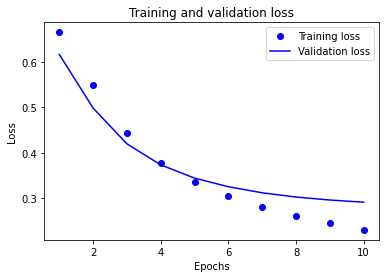

In [26]:
#from dictionary, plot the 2 loss points
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#"bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
#b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#model NOT overfitted - taining loss and val loss not too different
#could be because it has a dropout layer

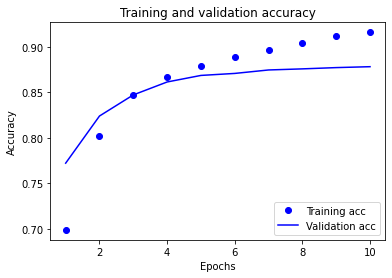

In [27]:
#from dictionary, plot the 2 accuracy points
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
#could add early_stopping to work against the overfitting

In [30]:
#export the model to be able to process raw strings
#build in a vectorization layer
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3103 - accuracy: 0.8734
0.8733599781990051


In [50]:
#visualize the model predictions by feeding it strings
examples = [
  "I enjoyed the humor of the movie.",
  "It was boring, it was ok.",
  "I hated this movie!"
]

arr = export_model.predict(examples)
print (arr)
x=0
for cell in arr:
  if ((arr[x]+0.5)>=1):
    print ("Positive")
  else:
    print ("Negative")
  x=x+1

[[0.65691894]
 [0.31427333]
 [0.47129405]]
Positive
Negative
Negative
